# Toronto neighborhood analysis for an Indian family to live in 

## 1. Introduction

**City of Toronto** is the most populous city in Canada. It is home to various ethnic groups such as Canadian, English, Chinese, Indian, Italian etc. It is recognized as one of the most multicultural and cosmopolitan cities in the world.

Toronto is an international center of business, finance and culture. The business and employment opportunities in Toronto leads to temporary or permanent immigration of many families. There is also a lot of internal migration from within Canada to Toronto. Reasons can be economic, arts, better standard of living, etc.

Migrating to a new city is not a simple task. One has to consider multiple facets while choosing a neighborhood to settle ex: Proximity to schools, colleges, hospitals, banks, hotels, etc. These are some of the basic important factors which a person should consider whenever he/she tries to relocate to a new city.

In this report, we will focus on Indian families that are planning to move to the great city of Toronto. 

## 2. Problem Statement

<h3>Enable an Indian family to select a neigbhorhood to relocate in the city of Toronto.</h3>
    
By reading this report, an Indian family can compare different neighborhoods and they should get an idea of the neighborhoods that they can consider for relocating in Toronto.

## 3. Data acquisition and preparation

<h3>A.</h3>We need to identify all the neighborhoods in the city of Toronto. Neighborhood details according to postal codes are available on the following wiki page https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050.

In [1]:
# @hidden_cell
import pandas as pd # library for data analsysis

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np # library to handle data in a vectorized manner

from matplotlib import pyplot
import seaborn as sns # Library for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print ("Libraries imported successfully")

     |████████████████████████████████| 92kB 12.2MB/s eta 0:00:01
Libraries imported successfully


In [2]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'

df = pd.read_html(url, header=0)[0] # read an html table and load it into a dataframe
print (df.shape)
df.head()

(287, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Remove the entries with no neighborhoods

In [3]:
df.rename(columns = {'Neighbourhood':'Neighborhood','Postcode':'Postal Code'}, inplace = True) 
df['Neighborhood'].replace('Not assigned',np.nan, inplace=True) # Replace text NaN with np.nan
df.dropna(axis=0, inplace=True)  # drop rows where NAN
df.reset_index(drop=True, inplace=True)
print (df.shape)
df.head()

(210, 3)


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


#### More than one neighborhood can exist in one postal code area. Combine neighbouhood with comma for each postal code. 

In [4]:
#Use Groupby on Postcode and Borough and apply String join function on Neigbourhood (Refer w3schools python string join tutorial)
df = df.groupby(['Postal Code','Borough'])['Neighborhood'].apply(','.join).reset_index()
print (df.shape)
df.head()

(103, 3)


,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<h3>B.</h3> We need to identify coordinates of each neighborhood. These are available at : http://cocl.us/Geospatial_data. 
This is a csv file that has the geographical coordinates of each postal code of Toronto



In [5]:
geo_data = pd.read_csv('http://cocl.us/Geospatial_data') # read csv having coordinate for postal code
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### let's combine the neighborhoods with geograpical coordinates using Postal Code. 

In [6]:
df_with_geo_data = pd.merge(df, geo_data, left_on='Postal Code',right_on='Postal Code', how='inner') 
df_with_geo_data.drop(['Postal Code'], axis=1, inplace=True) # drop duplicate postal code column
print (df_with_geo_data.shape)
df_with_geo_data.head()

(103, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


<h3>C.</h3> We need to identify important elements of each neighborhood such as schools, hospitals, parks etc. Since we are focusing on Indian family, it will be great if we could identify Hotels serving Indian food as well. This information can be accessed using third party Foursquare APIs.

**Foursquare** is a social location service that allows users to explore the world around them. Based on latitude and longitude, it will provide nearby services such as hotels, banks, stores, specific type of restaurants etc. A free Foursquare developer account has already been created for use.

#### Select categories to consider for evaluating a neighborhood.

For each neighbourhood identify the venues based on following categories: School, College & University,Bank, Hospital, Indian Restaurant, Grocery Store, SuperMarket, Shopping Mall and Pharmacy

Foursquare provides category ids for each venue category. These are available in their developer docs (https://developer.foursquare.com/docs/build-with-foursquare/categories/). Foursquare apis return accurate results when specified with correct category Ids.Following are the ids for our selected categories: 

- 4f4533804b9074f6e4fb0105 - Elementary school
- 4bf58dd8d48988d13d941735 - High school
- 4f4533814b9074f6e4fb0106 - Middle school
- 4f4533814b9074f6e4fb0107 - Nursery school
- 4bf58dd8d48988d10a951735 - Bank
- 4bf58dd8d48988d196941735 - Hospital
- 4bf58dd8d48988d10f941735 - Indian Restaurant
- 4bf58dd8d48988d118951735 - Grocery Store
- 52f2ab2ebcbc57f1066b8b46 - Supermarket
- 4bf58dd8d48988d10f951735 - Pharmacy


In [7]:
# @hidden_cell
CLIENT_ID = 'IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA' # your Foursquare ID
CLIENT_SECRET = 'M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG' # your Foursquare Secret
VERSION = '20200411' # Foursquare API version

#### Explore the neighborhoods and search for venues that belong to our category list within a radius of 1000 meters.

In [63]:
# For each given lattiude,longitude, explore the venue using foursquare api
# Convert output of api response into json and store the required information in a list
def exploreNeighborhood(names, latitudes, longitudes, radius, limit, categories):
    venues_list=[]
    #For each selected neighbourhood, explore it using foursquare explore api
    for name,lat,long in zip(names,latitudes,longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
           CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,radius,limit,categories)
        
        results = requests.get(url).json()
        if len(results["response"]) == 0:
            continue
            
        results = results["response"]['venues'] # parse the result to get items/venues
        venues_list.append([(
            name, 
            lat, 
            long, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])
      
    print ("Data fetched succesfully.")
    return (venues_list)

In [39]:
Toronto_df = df_with_geo_data
categories = '4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735'
radius=1000
limit=50 # Number of venues per search
exploration_results = exploreNeighborhood(Toronto_df['Neighborhood'],Toronto_df['Latitude'],Toronto_df['Longitude'],radius,limit,categories)


https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.806686299999996,-79.19435340000001&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.7845351,-79.16049709999999&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https:

https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.7785175,-79.3465557&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.7869473,-79.385975&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https://api.foursquare.com/v2

https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.695343900000005,-79.3183887&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.67635739999999,-79.2930312&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https://api.f

https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.6571618,-79.37893709999999&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.6514939,-79.3754179&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https://api.foursquar

https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.718517999999996,-79.46476329999999&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.709577,-79.44507259999999&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https:/

https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.60241370000001,-79.54348409999999&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https://api.foursquare.com/v2/venues/search?&client_id=IES25B4UWY215FFF3QSWXE5TAAQYYB4RJCTKESOXNA0PUYGA&client_secret=M5ZPM1KX30PYQVQ3UW1ZRA4IIUHLVZVOQP53VOZJSFXUWYWG&v=20200411&ll=43.653653600000005,-79.5069436&radius=1000&limit=50&categoryId=4bf58dd8d48988d10f941735,4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,4f4533814b9074f6e4fb0107,4bf58dd8d48988d10a951735,4bf58dd8d48988d196941735,4bf58dd8d48988d118951735,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d10f951735
https:

#### Convert data into a dataframe

In [37]:

Toronto_venues = pd.DataFrame([item for venue_list in exploration_results for item in venue_list]) # add each item in venue list to dataframe,
Toronto_venues.columns = ['Neighborhood', 
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
print ("Data converted successfully")

ValueError: Length mismatch: Expected axis has 0 elements, new values have 7 elements

#### let's check our data

In [11]:
print ("Total number or rows="+str(Toronto_venues.shape[0]) + " and Total number of columns = "+str(Toronto_venues.shape[1]))
print ("Example:")
Toronto_venues.head()

Total number or rows=388 and Total number of columns = 7
Example:


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
1,"Rouge,Malvern",43.806686,-79.194353,RBC Royal Bank,43.798782,-79.197090,Bank
2,"Rouge,Malvern",43.806686,-79.194353,Obsidian Mortgage Corporation & Financial Serv...,43.801100,-79.194131,Bank
3,"Rouge,Malvern",43.806686,-79.194353,Fusion Supermarket,43.800528,-79.200064,Supermarket
4,"Rouge,Malvern",43.806686,-79.194353,Meena's Fine Foods,43.804476,-79.199753,Indian Restaurant


In [12]:
Toronto_venues['Venue Category'].value_counts()

Bank                         100
Pharmacy                      68
Grocery Store                 54
Indian Restaurant             47
Elementary School             39
High School                   26
Supermarket                   14
Hospital                       9
South Indian Restaurant        6
Nursery School                 6
Chaat Place                    2
Indian Chinese Restaurant      2
Middle School                  2
School                         2
Pizza Place                    1
Café                           1
Medical Center                 1
Drugstore                      1
Butcher                        1
Food & Drink Shop              1
ATM                            1
Big Box Store                  1
Credit Union                   1
Sri Lankan Restaurant          1
Supplement Shop                1
Name: Venue Category, dtype: int64

#### Clean up the data for unwanted categories and merge similar categories

**#** Filter results to include specific categories

In [13]:
include_results = ["Bank","Pharmacy","Grocery Store","Indian Restaurant","South Indian Restaurant","North Indian Restaurant","Hospital","High School","Elementary School","Supermarket","Middle School","Nursery School","Hospital Ward","School","Health Food Store","Farmers Market","Gourmet Shop","Food & Drink Shop","Doctor's Office","Indian Chinese Restaurant","Convenience Store","Emergency Room","Medical Center","Chaat Place","Market","Fruit & Vegetable Store","Drugstore"]
filtered_Toronto_venues = Toronto_venues[Toronto_venues['Venue Category'].isin(include_results)]

filtered_Toronto_venues['Venue Category'].value_counts()

Bank                         100
Pharmacy                      68
Grocery Store                 54
Indian Restaurant             47
Elementary School             39
High School                   26
Supermarket                   14
Hospital                       9
South Indian Restaurant        6
Nursery School                 6
Chaat Place                    2
Middle School                  2
School                         2
Indian Chinese Restaurant      2
Food & Drink Shop              1
Drugstore                      1
Medical Center                 1
Name: Venue Category, dtype: int64

In [14]:
filtered_Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
1,"Rouge,Malvern",43.806686,-79.194353,RBC Royal Bank,43.798782,-79.197090,Bank
2,"Rouge,Malvern",43.806686,-79.194353,Obsidian Mortgage Corporation & Financial Serv...,43.801100,-79.194131,Bank
3,"Rouge,Malvern",43.806686,-79.194353,Fusion Supermarket,43.800528,-79.200064,Supermarket
4,"Rouge,Malvern",43.806686,-79.194353,Meena's Fine Foods,43.804476,-79.199753,Indian Restaurant


**#** Give a common label to similar categories. Example: "Indian Restaurant","South Indian Restaurant","North Indian Restaurant" and "Indian Chinese Restaurant" can be given a common label as "Indian Restaurant"

In [15]:
filtered_Toronto_venues_processed = filtered_Toronto_venues

#replace sub categories of indian restaurants with "Indian Restaurant"
filtered_Toronto_venues_processed['Venue Category'].replace(["Indian Restaurant","South Indian Restaurant","North Indian Restaurant","Indian Chinese Restaurant","Chaat Place"], "Indian Restaurant", inplace=True)
#replace food store categories with "Food store"
filtered_Toronto_venues_processed['Venue Category'].replace(["Grocery Store","Fruit & Vegetable Store","Food & Drink Shop","Gourmet Shop","Farmers Market","Health Food Store"],"Food store", inplace=True)
#replace medical entities with "Medical Center"
filtered_Toronto_venues_processed['Venue Category'].replace(["Pharmacy","Drugstore","Hospital","Hospital Ward","Doctor's Office","Emergency Room","Medical Center"], "Medical Center", inplace=True)
#replace school types with "School"
filtered_Toronto_venues_processed['Venue Category'].replace(["High School","Elementary School","Middle School","Nursery School","School"], "School", inplace=True)
#replace types of markets with "Supermarket"
filtered_Toronto_venues_processed['Venue Category'].replace(["Supermarket","Convenience Store","Market"], "Supermarket", inplace=True)

print("Updated categories to Common labels")
filtered_Toronto_venues_processed['Venue Category'].value_counts()



/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Updated categories to Common labels


Bank                 100
Medical Center        79
School                75
Indian Restaurant     57
Food store            55
Supermarket           14
Name: Venue Category, dtype: int64

In [16]:
print ("Total number or rows in the processed data = "+str(filtered_Toronto_venues_processed.shape[0]) + " and Total number of columns = "+str(filtered_Toronto_venues_processed.shape[1]))
filtered_Toronto_venues_processed.head()

Total number or rows in the processed data = 380 and Total number of columns = 7


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,School
1,"Rouge,Malvern",43.806686,-79.194353,RBC Royal Bank,43.798782,-79.197090,Bank
2,"Rouge,Malvern",43.806686,-79.194353,Obsidian Mortgage Corporation & Financial Serv...,43.801100,-79.194131,Bank
3,"Rouge,Malvern",43.806686,-79.194353,Fusion Supermarket,43.800528,-79.200064,Supermarket
4,"Rouge,Malvern",43.806686,-79.194353,Meena's Fine Foods,43.804476,-79.199753,Indian Restaurant


#### Use One Hot Encoding on Venue Category to convert categorical values in columns and mark the venue in the appropriate column

In [17]:
# Execute one hot encode on 'Venue Category'
dummies = pd.get_dummies(filtered_Toronto_venues_processed['Venue Category'])
# Merge the identified dummies with neighborhoods
Toronto_venues_temp = pd.concat([filtered_Toronto_venues_processed,dummies],axis=1)
# remove 'Venue Category','Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude' column as it has been one hot encoded
Toronto_venues_temp.drop(['Venue Category','Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude',],axis=1,inplace=True) 
Toronto_venues_temp.head()


,Neighborhood,Venue,Bank,Food store,Indian Restaurant,Medical Center,School,Supermarket
0,"Rouge,Malvern",Alvin Curling Public School,0,0,0,0,1,0
1,"Rouge,Malvern",RBC Royal Bank,1,0,0,0,0,0
2,"Rouge,Malvern",Obsidian Mortgage Corporation & Financial Serv...,1,0,0,0,0,0
3,"Rouge,Malvern",Fusion Supermarket,0,0,0,0,0,1
4,"Rouge,Malvern",Meena's Fine Foods,0,0,1,0,0,0


#### Find number of venues per category for each neighborhood

In [18]:
Toronto_grouped = Toronto_venues_temp.groupby('Neighborhood').sum().reset_index()
print ("Total number or rows in the grouped data = "+str(Toronto_grouped.shape[0]) + " and Total number of columns = "+str(Toronto_grouped.shape[1]))
Toronto_grouped.head()

Total number or rows in the grouped data = 22 and Total number of columns = 7


,Neighborhood,Bank,Food store,Indian Restaurant,Medical Center,School,Supermarket
0,Agincourt,4,4,3,3,1,3
1,"Agincourt North,L'Amoreaux East,Milliken,Steel...",3,2,0,6,5,0
2,Bayview Village,4,3,0,1,1,0
3,"Birch Cliff,Cliffside West",0,0,4,1,2,0
4,Cedarbrae,7,4,7,7,2,0


#### Since we are doing this study for an Indian family, we will not consider the neighborhoods with zero Indian Restaurants

In [19]:
Toronto_grouped['Indian Restaurant'].replace(0,np.nan,inplace=True)
Toronto_grouped.dropna(axis=0, inplace=True)  # drop rows where NAN
Toronto_grouped['Indian Restaurant'] = Toronto_grouped['Indian Restaurant'].astype('int64')
Toronto_grouped.reset_index(drop=True, inplace=True)
print ("Total number or rows in the grouped data = "+str(Toronto_grouped.shape[0]) + " and Total number of columns = "+str(Toronto_grouped.shape[1]))
Toronto_grouped.head()

Total number or rows in the grouped data = 16 and Total number of columns = 7


,Neighborhood,Bank,Food store,Indian Restaurant,Medical Center,School,Supermarket
0,Agincourt,4,4,3,3,1,3
1,"Birch Cliff,Cliffside West",0,0,4,1,2,0
2,Cedarbrae,7,4,7,7,2,0
3,"Clairlea,Golden Mile,Oakridge",3,2,2,5,2,0
4,"Clarks Corners,Sullivan,Tam O'Shanter",6,2,2,4,8,1


## 4. Methodology

#### Let's visualize our neighborhoods for top 20 venues per category

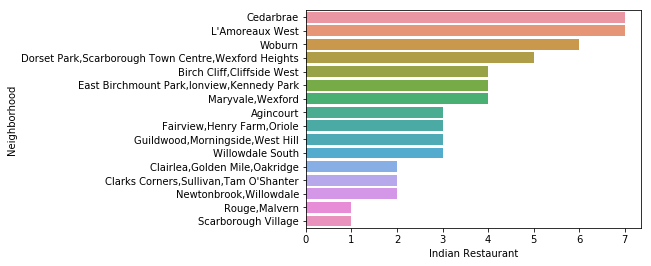

In [20]:
sns.barplot(y="Neighborhood", x="Indian Restaurant",data=Toronto_grouped.sort_values("Indian Restaurant",ascending=False)[0:20]);

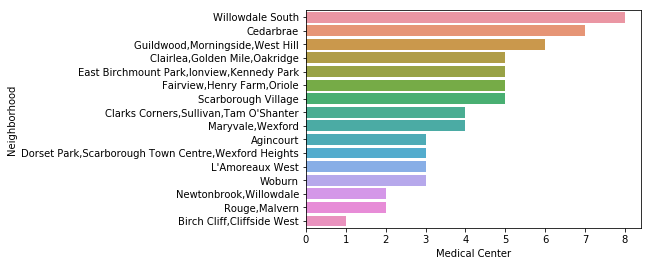

In [21]:
sns.barplot(y="Neighborhood", x="Medical Center",data=Toronto_grouped.sort_values("Medical Center",ascending=False)[0:20]);

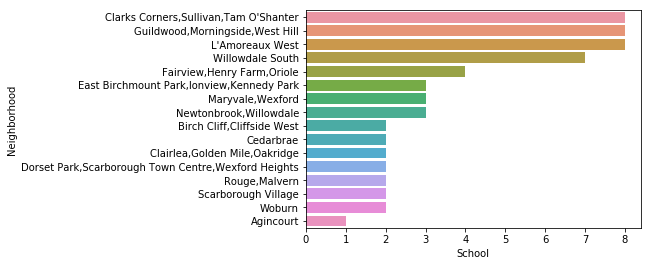

In [22]:
sns.barplot(y="Neighborhood", x="School",data=Toronto_grouped.sort_values("School",ascending=False)[0:20]);

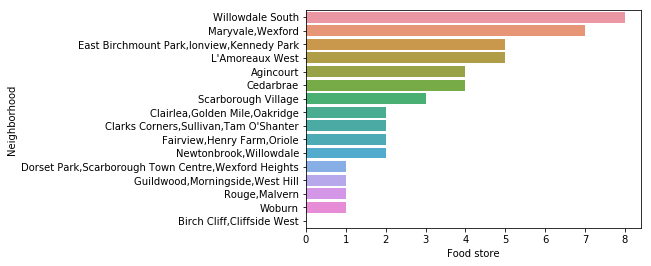

In [23]:
sns.barplot(y="Neighborhood", x="Food store",data=Toronto_grouped.sort_values("Food store",ascending=False)[0:20]);

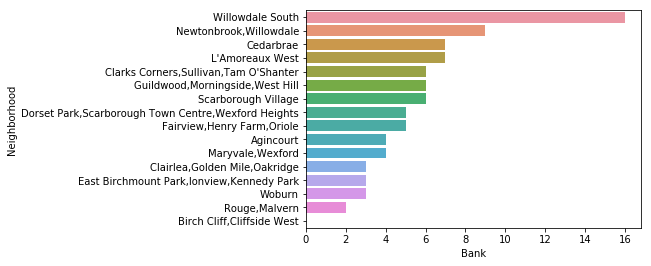

In [24]:
sns.barplot(y="Neighborhood", x="Bank",data=Toronto_grouped.sort_values("Bank",ascending=False)[0:20]);

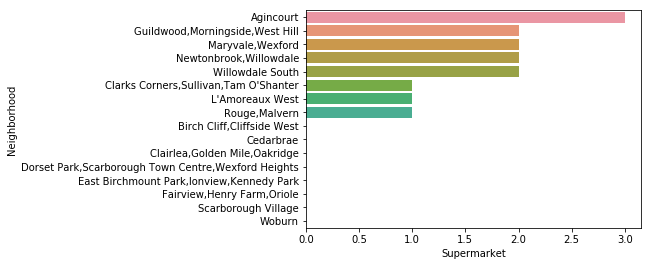

In [25]:
sns.barplot(y="Neighborhood", x="Supermarket",data=Toronto_grouped.sort_values("Supermarket",ascending=False)[0:20]);

#### Inference from visualizing data

As it is visible from the graphs above, the venue categories are not evenly spread across the neighborhoods. Some neighborhoods which have high number of medical centers, do not have enough schools. So, we can not say that a particular neighborhood is good for living based on only one category.

Using the essential venue categories, we can divide the neighborhoods into different segments. For this, we would need to calculate **livibality score** for each neighorhood.


#### Define "Livibality Score" for neighborhoods

Livability is the sum of the factors that add up to a community's quality of life.
Livibality score can be calculated using **"Weighted Average"** formula. Weighted average takes into account the variation in importance of the variables in a data set. In calculating a weighted average, each variable value in the data set is multiplied by a predetermined weight.

Following is the distribution on weights (out of total 100) given to each category: 

- Indian Restaurant - 30
- School - 20
- Food store - 20
- Supermarket - 15 
- Medical Center - 10
- Bank - 5          
       
Indian Restaurants are given the highest weight as it signifies the neighborhood's closeness to the Indian community.
While the Bank have been given the least weight as it is not an every day necessity.

This Livibality score will help an individual make a decision on which neighborhood to select.


#### Calculate "Livibality Score" for neighborhoods

In [26]:
# Mutiply each category column by its weight
Toronto_grouped['Score'] = (Toronto_grouped['Indian Restaurant']*30) + (Toronto_grouped['School'] * 20) + (Toronto_grouped['Food store']*20) + (Toronto_grouped['Supermarket'] * 15) + (Toronto_grouped['Medical Center']*10) + (Toronto_grouped['Bank'] * 5)
# Divide by total weight. In this case 100
Toronto_grouped['Score'] = Toronto_grouped['Score']/100
# Sort the dataframe by Score in a descending manner
Toronto_grouped.sort_values(by=['Score'],ascending=False,inplace=True)
Toronto_grouped.head(10)

,Neighborhood,Bank,Food store,Indian Restaurant,Medical Center,School,Supermarket,Score
0,Agincourt,4,4,3,3,1,3,2.85
1,"Birch Cliff,Cliffside West",0,0,4,1,2,0,1.70
2,Cedarbrae,7,4,7,7,2,0,4.35
3,"Clairlea,Golden Mile,Oakridge",3,2,2,5,2,0,2.05
4,"Clarks Corners,Sullivan,Tam O'Shanter",6,2,2,4,8,1,3.45


Now, we have the scores of each neighborhood. It would be useful to group similar neighborhoods together. We can do this using K-Means clustering algorithm. Based on their scores, we need to segment the neighborhoods into 3 groups: **Good, Moderate and Poor**. 
#### Let's create clusters of the neighborhoods using K-Means algorithm

In [42]:
# set number of clusters
kclusters = 3 # Good, Moderate and Poor

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering[['Score']])

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 1, 0], dtype=int32)

In [43]:
# add clustering labels to grouped data
Toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto geo data to add latitude/longitude for each neighborhood
Toronto_merged = df_with_geo_data
Toronto_merged = Toronto_merged.join(Toronto_grouped.set_index('Neighborhood'), on='Neighborhood',how='inner')
print ("Total number or rows in the data = "+str(Toronto_merged.shape[0]) + " and Total number of columns = "+str(Toronto_merged.shape[1]))
Toronto_merged.head()

Total number or rows in the data = 16 and Total number of columns = 12


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Bank,Food store,Indian Restaurant,Medical Center,School,Supermarket,Score
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,2,1,1,2,2,1,1.35
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,2,6,1,3,6,8,2,3.90
3,Scarborough,Woburn,43.770992,-79.216917,0,3,1,6,3,2,0,2.85
4,Scarborough,Cedarbrae,43.773136,-79.239476,2,7,4,7,7,2,0,4.35
5,Scarborough,Scarborough Village,43.744734,-79.239476,0,6,3,1,5,2,0,2.10


#### Visualize the clusters

To visualize the neighborhoods, we will use Folium map library. We will render the map of Toronto and using the coordinates of each neighborhood, we will highlight them on the map as a circle.

Each circle will represent a neighborhood and neighborhoods belonging to same cluster will have the same color.

In [44]:
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Toronto city'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [62]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = ['green','blue','red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, score in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels'],Toronto_merged['Score']):
    label = folium.Html(str(poi) + ' <br>Cluster: ' + str(cluster) + ' <br>Livability Score:' + str(score), script=True)
    pp = folium.Popup(label)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=pp,
        color=colors_array[cluster-1],
        fill=True,
        fill_color=colors_array[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
print("Toronto Neighborhoods:")       
map_clusters

Toronto Neighborhoods:
